In [ ]:
import numpy as np # NOTRE CODE 
from sklearn.preprocessing import normalize
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

class SphericalKMeans(BaseEstimator, ClusterMixin, TransformerMixin):
    """
    Implémentation académique complète du K-means sphérique.
    Optimisée pour la similarité cosinus (données sur l'hypersphère).
    """

    def __init__(self, n_clusters=3, max_iters=100, tol=1e-6, random_state=42, verbose=False):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        
    
        # Validation des paramètres
        if self.n_clusters < 1:
            raise ValueError("n_clusters doit être >= 1")
        if self.max_iters < 1:
            raise ValueError("max_iters doit être >= 1")

        # Attributs appris
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0
        self.history = {'inertia': [], 'centroid_shifts': []}

    def _initialize_centroids(self, X):
        """
        Initialisation K-means++ vectorisée pour la distance cosinus.
        Beaucoup plus rapide que la version itérative par échantillon.
        """
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        centroids = np.empty((self.n_clusters, n_features))
        
        # 1. Premier centre aléatoire
        rand_idx = np.random.randint(n_samples)
        centroids[0] = X[rand_idx]
        
        # Distances minimales au carré (1 - cos_sim)
        # On initialise avec une distance infinie ou très grande
        min_dist_sq = np.full(n_samples, np.inf)

        for i in range(1, self.n_clusters):
            # Calcul vectorisé de la distance entre tous les points X et le dernier centre choisi
            # Distance angulaire au carré approx = 1 - cosinus
            # Note: X est normalisé, centroids aussi. Dot product = cosinus.
            last_centroid = centroids[i-1]
            cosine_sims = X @ last_centroid
            dist_sq = 1.0 - cosine_sims
            
            # On garde la distance minimale trouvée jusqu'à présent pour chaque point
            min_dist_sq = np.minimum(min_dist_sq, dist_sq)
            
            # Probabilités proportionnelles au carré de la distance (K-Means++ standard)
            # Pour Spherical, on utilise souvent directement la distance angulaire
            probabilities = min_dist_sq
            
            sum_probs = np.sum(probabilities)
            if sum_probs == 0 or np.isnan(sum_probs):
                probabilities = np.ones(n_samples) / n_samples
            else:
                probabilities /= sum_probs
            
            # Sélection cumulative
            cumulative_probs = np.cumsum(probabilities)
            r = np.random.rand()
            selected_idx = np.searchsorted(cumulative_probs, r)
            
            # Sécurité pour éviter index out of bounds
            selected_idx = min(selected_idx, n_samples - 1)
            
            centroids[i] = X[selected_idx]
            
            if self.verbose:
                print(f"Init: centre {i+1}/{self.n_clusters} sélectionné.")

        return centroids

    def _assign_clusters(self, X, centroids):
        """Assigne chaque point au centre le plus proche (max cosinus)."""
        # Produit matriciel : (n_samples, n_features) @ (n_features, n_clusters)
        similarities = X @ centroids.T
        labels = np.argmax(similarities, axis=1)
        
        # Inertie : Somme des cosinus max (plus c'est haut, mieux c'est pour Spherical K-Means)
        # Note: Pour la distance euclidienne, on minimise l'inertie. 
        # Ici on maximise la similarité, donc on peut stocker la somme.
        inertia = np.sum(np.max(similarities, axis=1))
        
        return labels, inertia

    def _update_centroids(self, X, labels):
        """Recalcule les centres et les normalise."""
        new_centroids = np.zeros_like(self.centroids)
        
        for k in range(self.n_clusters):
            # Masque booléen pour sélectionner les points du cluster k
            mask = (labels == k)
            cluster_points = X[mask]
            
            if len(cluster_points) > 0:
                # Moyenne vectorielle
                centroid_mean = cluster_points.mean(axis=0)
                
                # Normalisation L2 (Projection sur la sphère)
                norm = np.linalg.norm(centroid_mean)
                if norm > 1e-10:
                    new_centroids[k] = centroid_mean / norm
                else:
                    # Cas dégénéré : vecteur nul, on garde l'ancien ou on réinitialise
                    new_centroids[k] = self.centroids[k]
            else:
                # Cluster vide : conservation de l'ancien centre
                if self.verbose:
                    print(f"Attention: Cluster {k} vide. Conservation du centre.")
                new_centroids[k] = self.centroids[k]
                
        return new_centroids

    def _check_convergence(self, new_centroids):
        """Vérifie si les centres ont bougé."""
        # Cosinus entre anciens et nouveaux centres (diagonale du produit matriciel)
        # np.einsum est efficace pour le dot product ligne par ligne
        cos_sims = np.einsum('ij,ij->i', self.centroids, new_centroids)
        shifts = 1.0 - cos_sims
        max_shift = np.max(shifts)
        return max_shift

    def fit(self, X, y=None):
        """Entraînement du modèle."""
        # 1. Validation et Normalisation
        X = np.array(X)
        if len(X.shape) != 2:
            raise ValueError("X doit être 2D")
            
        # Normalisation L2 critique pour Spherical K-Means
        X_normalized = normalize(X, norm='l2', axis=1)
        
        # 2. Initialisation
        if self.verbose:
            print(f"Démarrage fit sur {X.shape[0]} échantillons.")
            
        self.centroids = self._initialize_centroids(X_normalized)
        
        # 3. Boucle principale
        for iteration in range(self.max_iters):
            self.n_iter_ = iteration + 1
            
            # Etape E: Assignation
            labels, inertia = self._assign_clusters(X_normalized, self.centroids)
            
            # Etape M: Mise à jour
            new_centroids = self._update_centroids(X_normalized, labels)
            
            # Vérification convergence
            shift = self._check_convergence(new_centroids)
            
            # Historique
            self.history['inertia'].append(inertia)
            self.history['centroid_shifts'].append(shift)
            
            if self.verbose:
                print(f"Iter {iteration+1}: Inertia={inertia:.4f}, Shift={shift:.6f}")
            
            # Mise à jour des centres actuels
            self.centroids = new_centroids

            # Condition d'arrêt
            if shift < self.tol:
                if self.verbose:
                    print(f"Convergence atteinte à l'itération {iteration+1}")
                break
        
        # Assignation finale (pour être sûr que labels_ correspond aux centroids finaux)
        self.labels_, self.inertia_ = self._assign_clusters(X_normalized, self.centroids)
        
        return self

    def predict(self, X):
        """Prédiction pour de nouvelles données."""
        X_normalized = normalize(X, norm='l2', axis=1)
        similarities = X_normalized @ self.centroids.T
        return np.argmax(similarities, axis=1)

    def transform(self, X):
        """Retourne la matrice de similarité cosinus."""
        X_normalized = normalize(X, norm='l2', axis=1)
        return X_normalized @ self.centroids.T

    def score(self, X, y=None):
        """Retourne l'inertie (somme des similarités max)."""
        X_normalized = normalize(X, norm='l2', axis=1)
        similarities = X_normalized @ self.centroids.T
        return np.sum(np.max(similarities, axis=1))

Démarrage fit sur 300 échantillons.
Init: centre 2/4 sélectionné.
Init: centre 3/4 sélectionné.
Init: centre 4/4 sélectionné.
Iter 1: Inertia=228.6657, Shift=0.321384
Iter 2: Inertia=283.0664, Shift=0.187168
Iter 3: Inertia=297.6952, Shift=0.000000
Convergence atteinte à l'itération 3


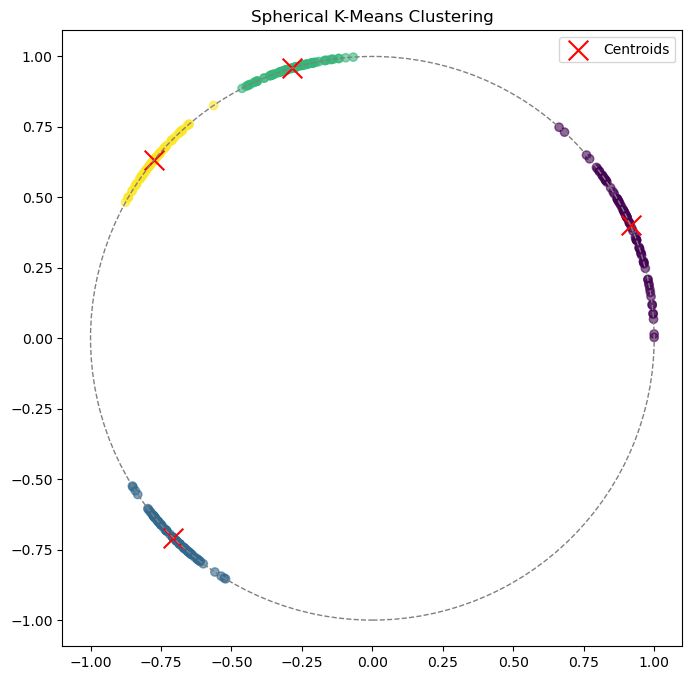

In [2]:
if __name__ == "__main__":# APPLICATION DE NOTRE CODE
    from sklearn.datasets import make_blobs
    import matplotlib.pyplot as plt

    # 1. Création de données sur un cercle (2D) pour visualiser
    X, y_true = make_blobs(n_samples=300, centers=4, n_features=2, random_state=42)
    
    # 2. Entraînement
    skm = SphericalKMeans(n_clusters=4, verbose=True)
    skm.fit(X)

    # 3. Prédiction
    labels = skm.predict(X)

    # 4. Visualisation (Projection sur le cercle unitaire)
    X_norm = normalize(X)
    
    plt.figure(figsize=(8, 8))
    # Points
    plt.scatter(X_norm[:, 0], X_norm[:, 1], c=labels, cmap='viridis', alpha=0.6)
    # Centroïdes
    plt.scatter(skm.centroids[:, 0], skm.centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
    
    # Cercle unitaire pour référence
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_patch(circle)
    
    plt.title("Spherical K-Means Clustering")
    plt.legend()
    plt.axis('equal')
    plt.show()

=== Spherical K-Means Personnalisé ===
Iteration 1, centroid shift: 0.452902
Iteration 2, centroid shift: 0.026425
Iteration 3, centroid shift: 0.031454
Iteration 4, centroid shift: 0.019662
Iteration 5, centroid shift: 0.005016
Iteration 6, centroid shift: 0.000000
Converged after 6 iterations

=== K-means Standard (scikit-learn) ===

=== RÉSULTATS ===
Spherical K-Means ARI: 0.6303
Standard K-Means ARI:  1.0000


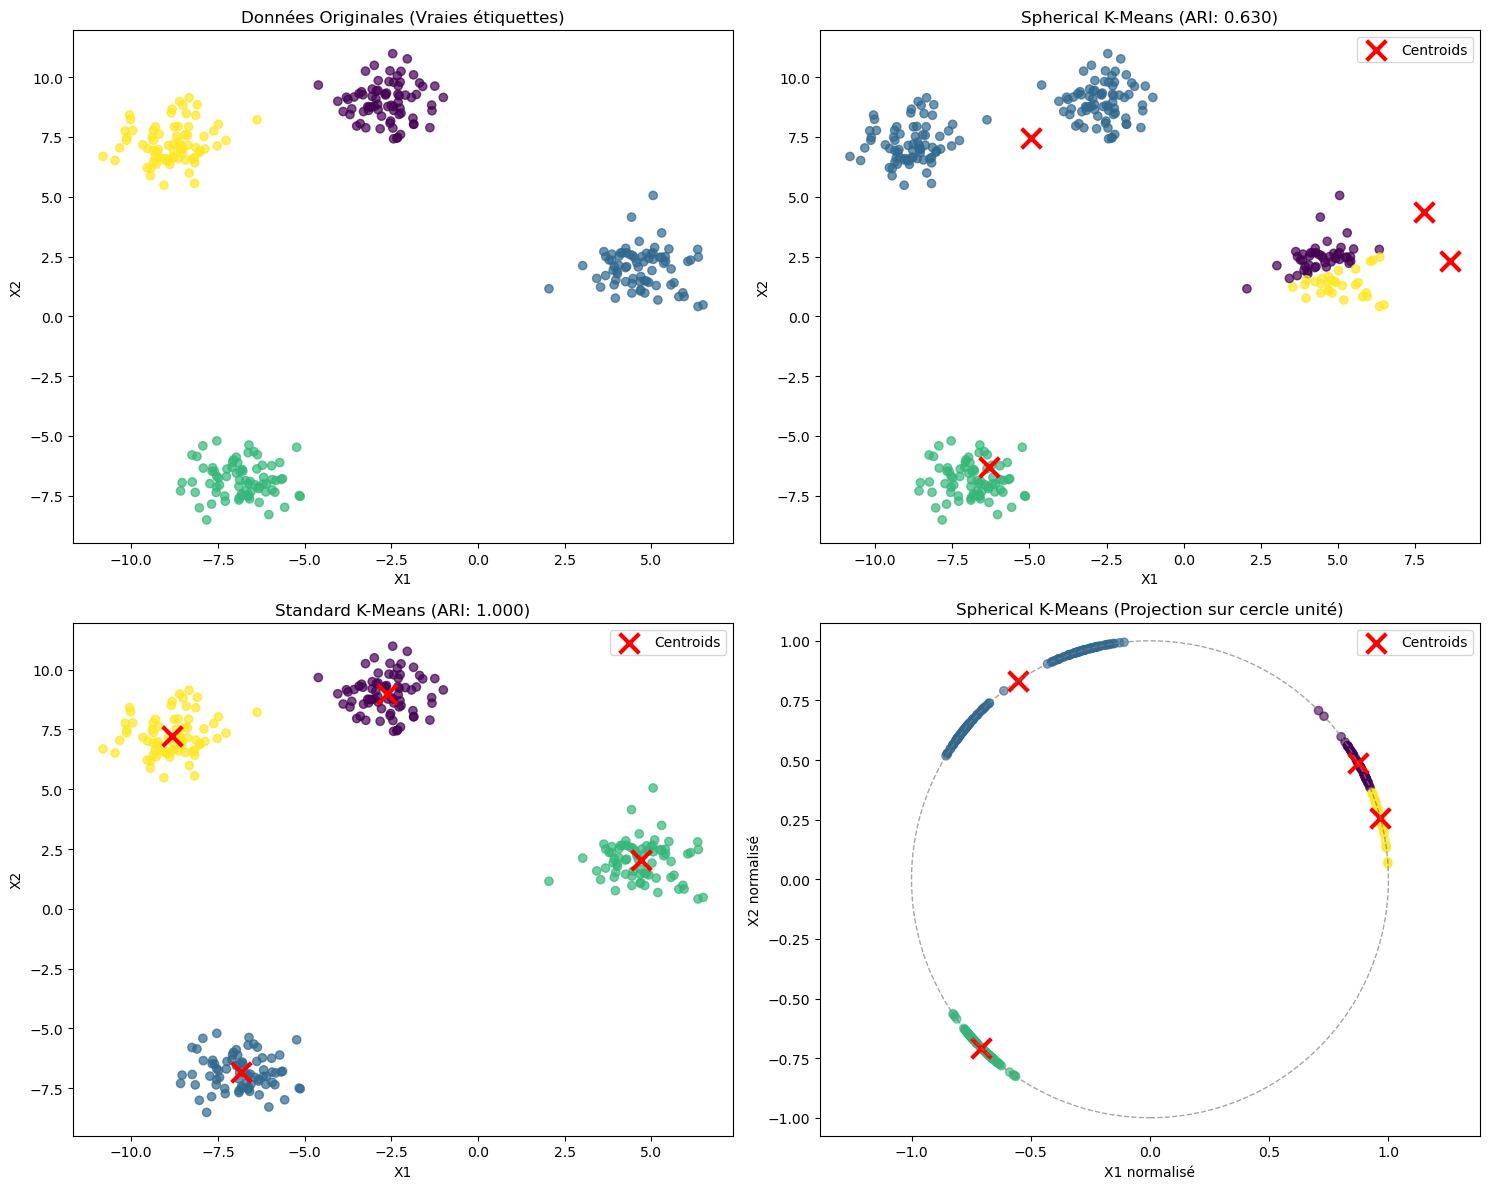


=== COMPARAISON DES CENTROÏDES ===
Spherical K-Means centroids (normalisés):
[[ 0.87343673  0.48693765]
 [-0.55286843  0.83326856]
 [-0.70668044 -0.70753286]
 [ 0.96626703  0.25754227]]

Standard K-Means centroids:
[[-2.63715917  8.98563949]
 [-6.84180708 -6.84038791]
 [ 4.70253968  2.02807134]
 [-8.83330596  7.21790214]]


In [ ]:
import numpy as np # COMPARAISON DE NOTRE CODE ET CELLE DU SCIKIT-LEARN
import matplotlib.pyplot as plt
    from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

class SphericalKMeans:
    def __init__(self, n_clusters=4, max_iters=100, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.verbose = verbose
        self.centroids = None
        
    def fit(self, X):
        # Normaliser les données sur la sphère unité
        X_norm = normalize(X)
        
        # Initialisation aléatoire des centroïdes
        n_samples = X_norm.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X_norm[random_indices]
        
        for iteration in range(self.max_iters):
            # Étape d'affectation : assigner chaque point au centroïde le plus proche (cosine similarity)
            distances = 1 - np.dot(X_norm, self.centroids.T)  # 1 - cosine similarity
            labels = np.argmin(distances, axis=1)
            
            # Étape de mise à jour : mettre à jour les centroïdes
            new_centroids = np.zeros_like(self.centroids)
            for i in range(self.n_clusters):
                cluster_points = X_norm[labels == i]
                if len(cluster_points) > 0:
                    # Moyenne des vecteurs du cluster et normalisation
                    new_centroids[i] = cluster_points.mean(axis=0)
                    new_centroids[i] = new_centroids[i] / np.linalg.norm(new_centroids[i])
                else:
                    # Réinitialiser si cluster vide
                    new_centroids[i] = X_norm[np.random.randint(0, n_samples)]
            
            # Vérifier la convergence
            centroid_shift = np.linalg.norm(new_centroids - self.centroids)
            if self.verbose:
                print(f"Iteration {iteration + 1}, centroid shift: {centroid_shift:.6f}")
            
            if centroid_shift < self.tol:
                if self.verbose:
                    print(f"Converged after {iteration + 1} iterations")
                break
                
            self.centroids = new_centroids
            
        return self
    
    def predict(self, X):
        X_norm = normalize(X)
        distances = 1 - np.dot(X_norm, self.centroids.T)
        return np.argmin(distances, axis=1)

def compare_kmeans():
    # 1. Création des données
    X, y_true = make_blobs(n_samples=300, centers=4, n_features=2, 
                          cluster_std=0.8, random_state=42)
    
    # Normaliser les données pour la visualisation sur le cercle unité
    X_norm = normalize(X)
    
    # 2. Spherical K-Means personnalisé
    print("=== Spherical K-Means Personnalisé ===")
    skm = SphericalKMeans(n_clusters=4, verbose=True, max_iters=100)
    skm.fit(X)
    labels_skm = skm.predict(X)
    
    # 3. K-means standard de scikit-learn
    print("\n=== K-means Standard (scikit-learn) ===")
    km = KMeans(n_clusters=4, random_state=42, max_iter=100, n_init=1)
    labels_km = km.fit_predict(X)
    
    # 4. Évaluation avec les vraies étiquettes
    ari_skm = adjusted_rand_score(y_true, labels_skm)
    ari_km = adjusted_rand_score(y_true, labels_km)
    
    print(f"\n=== RÉSULTATS ===")
    print(f"Spherical K-Means ARI: {ari_skm:.4f}")
    print(f"Standard K-Means ARI:  {ari_km:.4f}")
    
    # 5. Visualisation comparative
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Données originales
    axes[0, 0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.7)
    axes[0, 0].set_title('Données Originales (Vraies étiquettes)')
    axes[0, 0].set_xlabel('X1')
    axes[0, 0].set_ylabel('X2')
    
    # Spherical K-Means - données originales
    axes[0, 1].scatter(X[:, 0], X[:, 1], c=labels_skm, cmap='viridis', alpha=0.7)
    axes[0, 1].scatter(skm.centroids[:, 0] * np.mean(np.linalg.norm(X, axis=1)), 
                       skm.centroids[:, 1] * np.mean(np.linalg.norm(X, axis=1)), 
                       c='red', marker='x', s=200, linewidth=3, label='Centroids')
    axes[0, 1].set_title(f'Spherical K-Means (ARI: {ari_skm:.3f})')
    axes[0, 1].set_xlabel('X1')
    axes[0, 1].set_ylabel('X2')
    axes[0, 1].legend()
    
    # Standard K-Means - données originales
    axes[1, 0].scatter(X[:, 0], X[:, 1], c=labels_km, cmap='viridis', alpha=0.7)
    axes[1, 0].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 
                       c='red', marker='x', s=200, linewidth=3, label='Centroids')
    axes[1, 0].set_title(f'Standard K-Means (ARI: {ari_km:.3f})')
    axes[1, 0].set_xlabel('X1')
    axes[1, 0].set_ylabel('X2')
    axes[1, 0].legend()
    
    # Visualisation sur le cercle unité (Spherical K-Means)
    axes[1, 1].scatter(X_norm[:, 0], X_norm[:, 1], c=labels_skm, cmap='viridis', alpha=0.6)
    axes[1, 1].scatter(skm.centroids[:, 0], skm.centroids[:, 1], 
                       c='red', marker='x', s=200, linewidth=3, label='Centroids')
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.7)
    axes[1, 1].add_patch(circle)
    axes[1, 1].set_title('Spherical K-Means (Projection sur cercle unité)')
    axes[1, 1].set_xlabel('X1 normalisé')
    axes[1, 1].set_ylabel('X2 normalisé')
    axes[1, 1].legend()
    axes[1, 1].axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Comparaison des centroïdes
    print(f"\n=== COMPARAISON DES CENTROÏDES ===")
    print("Spherical K-Means centroids (normalisés):")
    print(skm.centroids)
    print("\nStandard K-Means centroids:")
    print(km.cluster_centers_)

if __name__ == "__main__":
    compare_kmeans()